In [1]:
%load_ext autoreload
%autoreload 2
# %config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from dataclasses import dataclass


In [4]:
from scipy.special import expi

In [5]:
import vice
import surp
from surp import gce_math as gcem

In [6]:
surp.yields.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 4.40e-02 (Z - Z0)   1.50 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
y0_agb  0.00038
z0_agb  -0.01
agb_model:  cristallo11
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




In [83]:
def sfh_2exp(tau_rise=2, tau_sfh=5):
    return lambda t: np.exp(-t/tau_sfh) * (1 - np.exp(-t/tau_rise))

In [95]:
sz_f = sz_model(params=sz_params(η=0,),sfh=sfh_2exp(), model="C11", mode="ifr")

In [96]:
h["[c/mg]"][-1]

-0.012778456320508225

In [97]:
h["[M/H]"][-1]

0.5448586077236086

In [98]:
def calc_y(Z=gcem.Z_SUN, ele="c"):
    m_c, times = vice.single_stellar_population(ele, Z=Z, mstar=1)
    return m_c[-1]

calc_y = np.vectorize(calc_y)

def calc_c_a(M_H):
    Z = gcem.MH_to_Z(M_H)
    return gcem.abund_to_brak(calc_y(Z, "c") / calc_y(Z, "mg"), "c", "mg")

In [99]:
calc_c_a(0.2)

-0.03708476422728868

In [100]:
h["[mg/h]"][-1]

0.5458826311923324

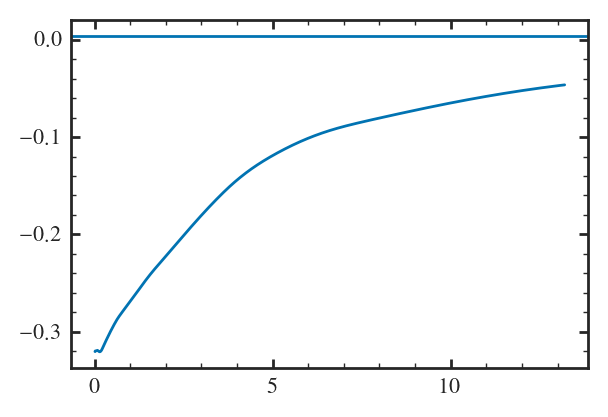

In [101]:
h = sz_f.history
plt.plot(h["time"], h["[c/mg]"])
plt.axhline(calc_c_a(h["[mg/h]"][-1]))

In [9]:
surp.yields.set_yields(agb_model="A", a_agb_kwargs=dict(zeta_agb=0))

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 2.90e-02 (Z - Z0)   (5.70e-04 + 0.00e+00(Z-Zo)),   0                              
                                                   t_D=0.15, tau=0.30                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
Y agb 0.0005700000000000001
zeta agb 0.0
agb_model:  A
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




In [10]:
@dataclass
class sz_params:
    η: float = 0.5
    r: float = 0.4
    τ_star: float = 2
        
    t_d_agb: float = 0.1
    τ_agb: float = 0.1
        
    y_c_agb: float = vice.yields.agb.settings["c"].y0
    y_c_cc: float = vice.yields.ccsne.settings["c"].y0
    ζ_c_agb: float = vice.yields.ccsne.settings["c"].zeta
    ζ_c_cc: float = vice.yields.agb.settings["c"].zeta
        
    y_o = vice.yields.ccsne.settings["o"]
    y_fe_cc: float = vice.yields.ccsne.settings["fe"]
    y_fe_ia: float = vice.yields.sneia.settings["fe"]
        
    τ_ia: float = 1.5
    κ_ia: float = -1.1
    t_d_ia: float = 0.15
        
    t_end: float = 13.2
    
        
    @property 
    def ϖ(self):
        return 1 / self.τ_dep
    
    @property
    def τ_dep(self):
        return self.τ_star / (1 + self.η - self.r)

In [11]:
def ϵ(t):
    return np.exp(-t)

def ξ(t):
    return t*np.exp(-t)

In [12]:
def cc_model(t, y, params = sz_params()):
    ϖ = params.ϖ
    s = 1 - ϵ(ϖ * t)
    return y / params.τ_star * s / ϖ


def fe_ia_model(t, params = sz_params()):
    ϖ = params.ϖ
    ι = 1 / params.τ_ia
    
    δt = t - params.t_d_ia
    
    s = 1 
    s += - ϖ/(ϖ - ι) * ϵ(ι * δt)
    s += + ι/(ϖ - ι) * ϵ(ϖ * δt)
    s = np.where(δt <= 0, 0, s)
    
    Zeq = params.y_fe_ia / params.τ_star  / ϖ
    return Zeq * s


def Γ(κ, t):
    return -gammainc(κ, t)


def R_int_ia(t, params=sz_params()):
    κ = params.κ_ia
    t_d = params.t_d_ia    
    R0 = (κ + 1) / (params.t_end**(κ + 1) - t_d**(κ + 1))

    r = t**(κ+1) - t_d**(κ+1)
    return r * R0 / (κ + 1)

def fe_ia_model2(t, params=sz_params()):
    ϖ = params.ϖ
    κ = params.κ_ia
    t_d = params.t_d_ia
    
    t = np.array(t)
    
    Zeq = params.y_fe_ia / params.τ_star * 1 / ϖ
    R0 = (κ + 1) / (0 - t_d**(κ + 1))
    
    Γ0 = Γ(κ+2, -ϖ*t_d)
    coef = (-ϖ)**(-κ - 1)
    c = np.array([
        float(
            (coef * (Γ(κ+2, -ϖ*x) - Γ0)
            ).real) for x in t])
    
    i = np.array([
        float(
            (coef * (Γ(κ+2, -ϖ*x) - Γ0)
            ).imag) for x in t])
    
    s =  -ϵ(ϖ*t) * c
    s += -t_d**(κ + 1) * (1 - ϵ(ϖ*t - ϖ*t_d))
    
    s = np.where(t >= t_d, s, 0)

    return s * Zeq  * R0 / (κ + 1)

def fe_model(t, params=sz_params()):
    Zcc = cc_model(t, params.y_fe_cc, params)
    Zia = fe_ia_model(t, params)
    
    return Zcc + Zia


In [13]:
def c_agb_model(t, params=sz_params()):
    α = 1/params.τ_agb
    ϖ = params.ϖ
    δt = t - params.t_d_agb
    
    s = 1 / ϖ 
    s += 1/(α - ϖ) * ξ(α * δt)
    s += (2*α- ϖ) / (α - ϖ)**2 * ϵ(α * δt)
    s += -(1/ϖ + (2*α- ϖ) / (α - ϖ)**2) * ϵ(ϖ * δt)
    
    s = np.where(δt < 0, 0, s)

    return params.y_c_agb * s / params.τ_star



def c_model(t, params=sz_params()):
    Zagb = c_agb_model(t, params)
    Zcc = cc_model(t, params.y_c_cc, params)
    return Zagb + Zcc

In [50]:
def sfh_const():
    return lambda t: 1 + 0*t


def set_yields(params = sz_params(), model="A"):
    if model == "A":
        surp.yields.set_yields(
            agb_model="A", 
            zeta_cc=0, 
            a_agb_kwargs=dict(
                tau_agb = params.τ_agb,
                t_D = params.t_d_agb,
                zeta_agb = 0,
            
        ))
        

    
def sz_model(dt=0.01, t_end=13.2, sfh=sfh_const(), params=sz_params(), mode="gas", RIa="exp", **kwargs):
    set_yields(params, **kwargs)
    
    sz = vice.singlezone(elements=["o", "mg", "c", "fe"], func=sfh, mode=mode, dt=dt, 
                         eta=params.η,  tau_star=params.τ_star, Mg0=1)
    
    sz.RIa = RIa
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [51]:
def o_model(t, params=sz_params()):
    return cc_model(t, params.y_o)

In [56]:
sz = sz_model()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 0.00e+00 (Z - Z0)   (5.70e-04 + 0.00e+00(Z-Zo)),   0                              
                                                   t_D=0.10, tau=0.10                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
Y agb 0.0005700000000000001
zeta agb 0.0
agb_model:  A
0.002850 + 0.000000 (Z-Zo)
f_agb = 0.2000




In [57]:
zo = np.array(sz.history["z(o)"])
zfe = np.array(sz.history["z(fe)"])
zc = np.array(sz.history["z(c)"])
t = np.array(sz.history["time"])


o_h = gcem.abund_to_brak(zo, "o")
c_o = gcem.abund_to_brak(zc/zo, "c", "o")
o_fe = gcem.abund_to_brak(zo/zfe, "o", "fe")


zo_a = o_model(t)
zfe_a = fe_model(t)
zc_a = c_model(t)

o_h_a = gcem.abund_to_brak(zo_a, "o")
c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")

/tmp/slurmtmp.26279766/ipykernel_266144/92208733.py:8: RuntimeWarning: invalid value encountered in divide
  c_o = gcem.abund_to_brak(zc/zo, "c", "o")
/tmp/slurmtmp.26279766/ipykernel_266144/92208733.py:9: RuntimeWarning: invalid value encountered in divide
  o_fe = gcem.abund_to_brak(zo/zfe, "o", "fe")
/tmp/slurmtmp.26279766/ipykernel_266144/92208733.py:17: RuntimeWarning: invalid value encountered in divide
  c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
/tmp/slurmtmp.26279766/ipykernel_266144/92208733.py:18: RuntimeWarning: invalid value encountered in divide
  o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")


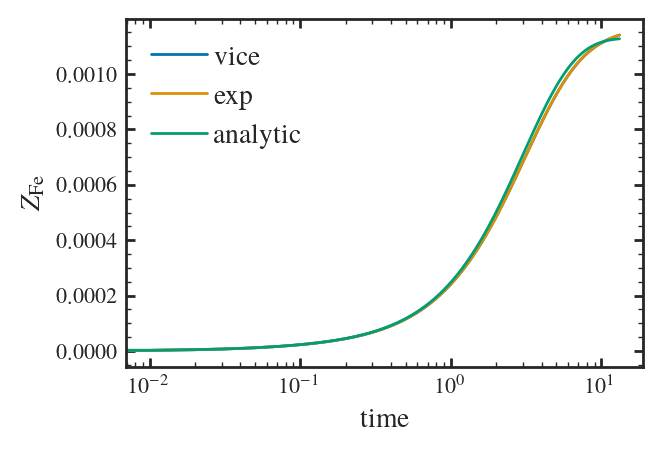

In [58]:

plt.plot(t, zfe, label="vice")
plt.plot(sz_e.history['time'], sz_e.history["z(fe)"], label="exp")

plt.plot(t, zfe_a, label="analytic")

plt.xscale('log')
plt.xlabel("time")
plt.ylabel(r"$Z_{\rm Fe}$")
plt.legend()


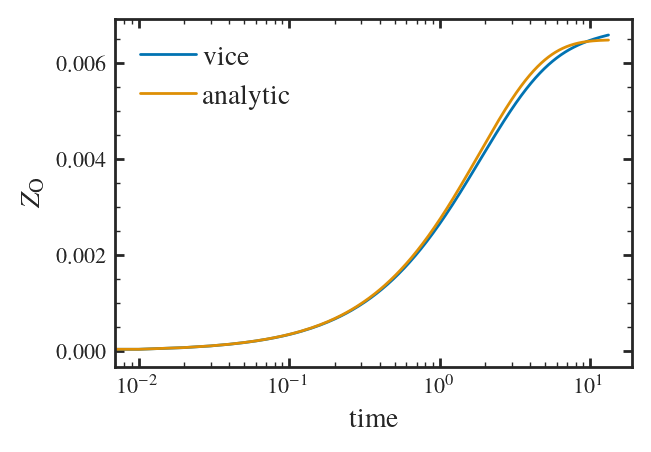

In [59]:

plt.plot(t, zo, label="vice")

plt.plot(t, zo_a, label="analytic")

plt.xscale("log")
plt.xlabel("time")
plt.ylabel(r"$Z_{\rm O}$")

plt.legend()

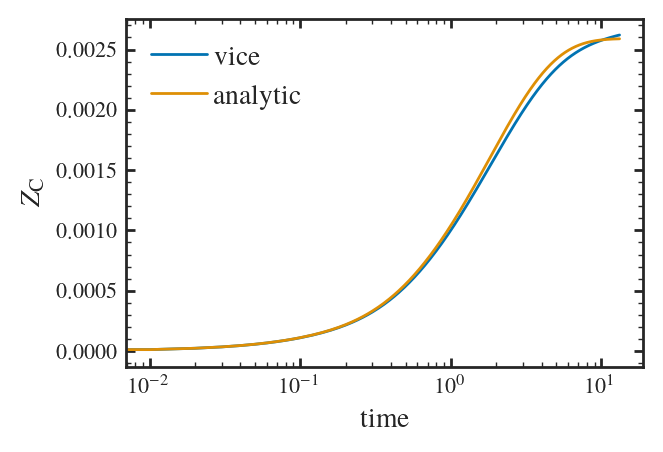

In [60]:
plt.plot(t, zc, label="vice")
plt.plot(t, zc_a, label="analytic", ls="-")

plt.xscale('log')
plt.xlabel("time")
plt.ylabel(r"$Z_{\rm C}$")
plt.legend()


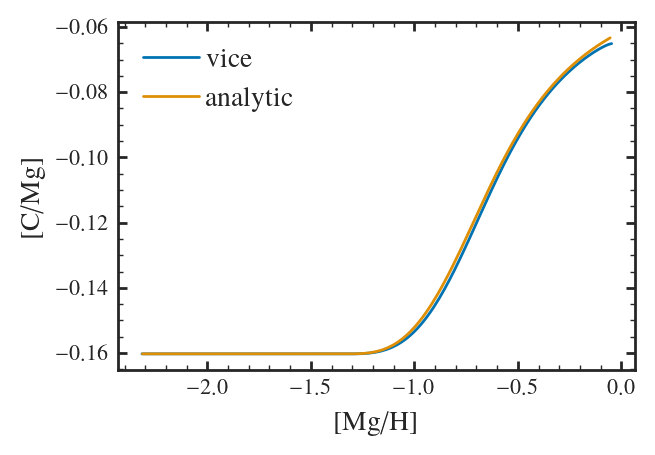

In [61]:
plt.plot(o_h, c_o, label="vice")
plt.plot(o_h_a, c_o_a, label="analytic")

plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.legend()

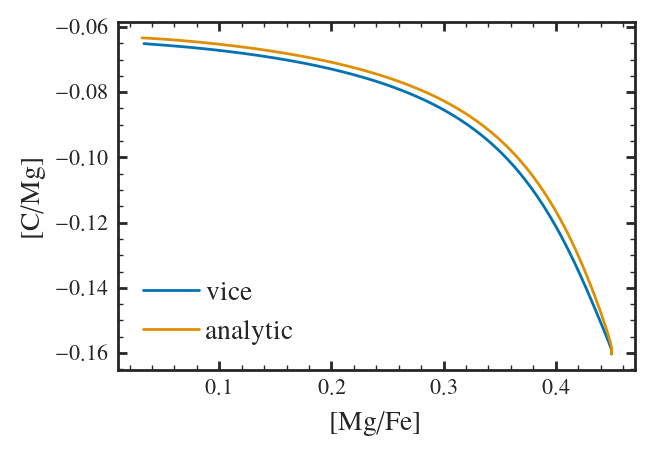

In [62]:
plt.plot(o_fe, c_o, label="vice")
plt.plot(o_fe_a, c_o_a, label="analytic")

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.legend()

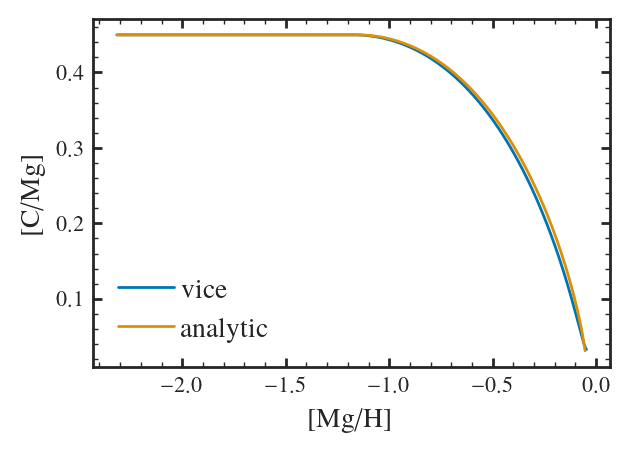

In [63]:
plt.plot(o_h, o_fe, label="vice")
plt.plot(o_h_a, o_fe_a, label="analytic")

plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.legend()